## Toxic: TF-IDF/NMF

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.pipeline import Pipeline

from wordcloud import WordCloud

from time import time

In [2]:
df = pd.read_pickle('../data/toxictrain.pkl')
print(df.shape)
# df.head()

(159571, 24)


### Assumptions

In [4]:
n_samples = 2000
n_features = 1000

class_list = ['clean','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
model_list = ['LDA','NMF','NMF-KL']

class_tfidfnmf = {}

In [5]:
def print_top_words(model, feature_names, n_top_words):
    listy = []
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        listy.append(message)
    return listy
    

def tfidf_nmf_dict(dataset,n_components,n_top_words):
    class_list = ['clean','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']
    class_tfidfnmf = {}
    
    for item in class_list:
        data = df[df[item]==1]

        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=1,max_features=n_features,stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(data.comment_text_s)
        
        tf_vectorizer = CountVectorizer(max_df=0.95, min_df=1,max_features=n_features,stop_words='english')
        tf = tf_vectorizer.fit_transform(data.comment_text_s)
        
        nmf = NMF(n_components=n_components, random_state=1,alpha=.1, l1_ratio=.5).fit(tfidf)
        
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()

        aa = print_top_words(nmf, tfidf_feature_names, n_top_words)
        
        nmf = NMF(n_components=n_components, random_state=1,beta_loss='kullback-leibler', solver='mu', 
                  max_iter=1000, alpha=.1,l1_ratio=.5).fit(tfidf)
        
        tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
        bb = print_top_words(nmf, tfidf_feature_names, n_top_words)
        
        lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,learning_method='online',
                                        learning_offset=50.,random_state=0)
        lda.fit(tf)
        
        tf_feature_names = tf_vectorizer.get_feature_names()
        
        cc = print_top_words(lda, tf_feature_names, n_top_words)
        class_tfidfnmf[item] = {'NMF':aa, 'NMF-KL':bb, 'LDA':cc}
    
    return class_tfidfnmf

In [18]:
tnd = tfidf_nmf_dict(df,1,50)

In [19]:
tnd = pd.DataFrame(tnd)
tnd

clean  \
LDA     [Topic #0: article page wikipedia talk just li...   
NMF     [Topic #0: talk article page wikipedia just li...   
NMF-KL  [Topic #0: talk wikipedia page article just li...   

                                            identity_hate  \
LDA     [Topic #0: nigger gay fuck fucking jew fat lik...   
NMF     [Topic #0: gay fuck faggot fucking nigger shit...   
NMF-KL  [Topic #0: gay fuck fucking faggot nigger like...   

                                                   insult  \
LDA     [Topic #0: fuck fucking like wikipedia don jus...   
NMF     [Topic #0: fuck fucking bitch shit asshole ass...   
NMF-KL  [Topic #0: fuck fucking wikipedia shit like st...   

                                                  obscene  \
LDA     [Topic #0: fuck fucking shit wikipedia like do...   
NMF     [Topic #0: fuck fucking shit bitch wikipedia a...   
NMF-KL  [Topic #0: fuck fucking shit wikipedia like su...   

                                             severe_toxic  \
LDA     [Topic #0: fuck shit suck fucking ass bitch su...   
NMF     [Topic #0: fuck bitch fucking asshole shit ass...   
NMF-KL  [Topic #0: fuck fucking shit suck bitch wikipe...   

                                                   threat  \
LDA     [Topic #0: die kill ass going fuck fucking wik...   
NMF     [Topic #0: die kill fucking fuck hope shit goi...   
NMF-KL  [Topic #0: kill die going fucking fuck hope sh...   

                                                    toxic  
LDA     [Topic #0: fuck wikipedia like just don page p...  
NMF     [Topic #0: fuck fucking shit wikipedia don bit...  
NMF-KL  [Topic #0: fuck wikipedia like fucking just sh...

In [20]:
tnd1 = tnd.loc['LDA','clean'][0].split()[2:]

In [59]:
def create_wordcloud(text,width,height,max_words,title,filepath):
    wordcloud = WordCloud(width=width,height=height,max_words=max_words).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(title,fontweight='bold',fontsize=16)
    plt.savefig(filepath)
    
def prep_dict(dictionary, model_list):
    fig = plt.figure(figsize=(20,60))
    model_words = {}
    i = 0
    for item in class_list:
        for mod in model_list:
            ax = fig.add_subplot(11,2,i+1)
            data = dictionary.loc[mod,item][0].split()[2:]
            text = ' '.join(data)
            title = str(mod + " Topic: " + item)
            filepath = '../charts/TFIDFNMF_wc_' + mod + "_" + item + '.png'
            create_wordcloud(text,400,200,200,title,filepath)
            print('file saved at ' + filepath)
            model_words[(item,mod)] = data
            i +=1
    return model_words

file saved at ../charts/TFIDFNMF_wc_LDA_clean.png
file saved at ../charts/TFIDFNMF_wc_NMF_clean.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_clean.png
file saved at ../charts/TFIDFNMF_wc_LDA_toxic.png
file saved at ../charts/TFIDFNMF_wc_NMF_toxic.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_toxic.png
file saved at ../charts/TFIDFNMF_wc_LDA_severe_toxic.png
file saved at ../charts/TFIDFNMF_wc_NMF_severe_toxic.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_severe_toxic.png
file saved at ../charts/TFIDFNMF_wc_LDA_obscene.png
file saved at ../charts/TFIDFNMF_wc_NMF_obscene.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_obscene.png
file saved at ../charts/TFIDFNMF_wc_LDA_threat.png
file saved at ../charts/TFIDFNMF_wc_NMF_threat.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_threat.png
file saved at ../charts/TFIDFNMF_wc_LDA_insult.png
file saved at ../charts/TFIDFNMF_wc_NMF_insult.png
file saved at ../charts/TFIDFNMF_wc_NMF-KL_insult.png
file saved at ../charts/TFIDFNMF_wc_LDA_identity_

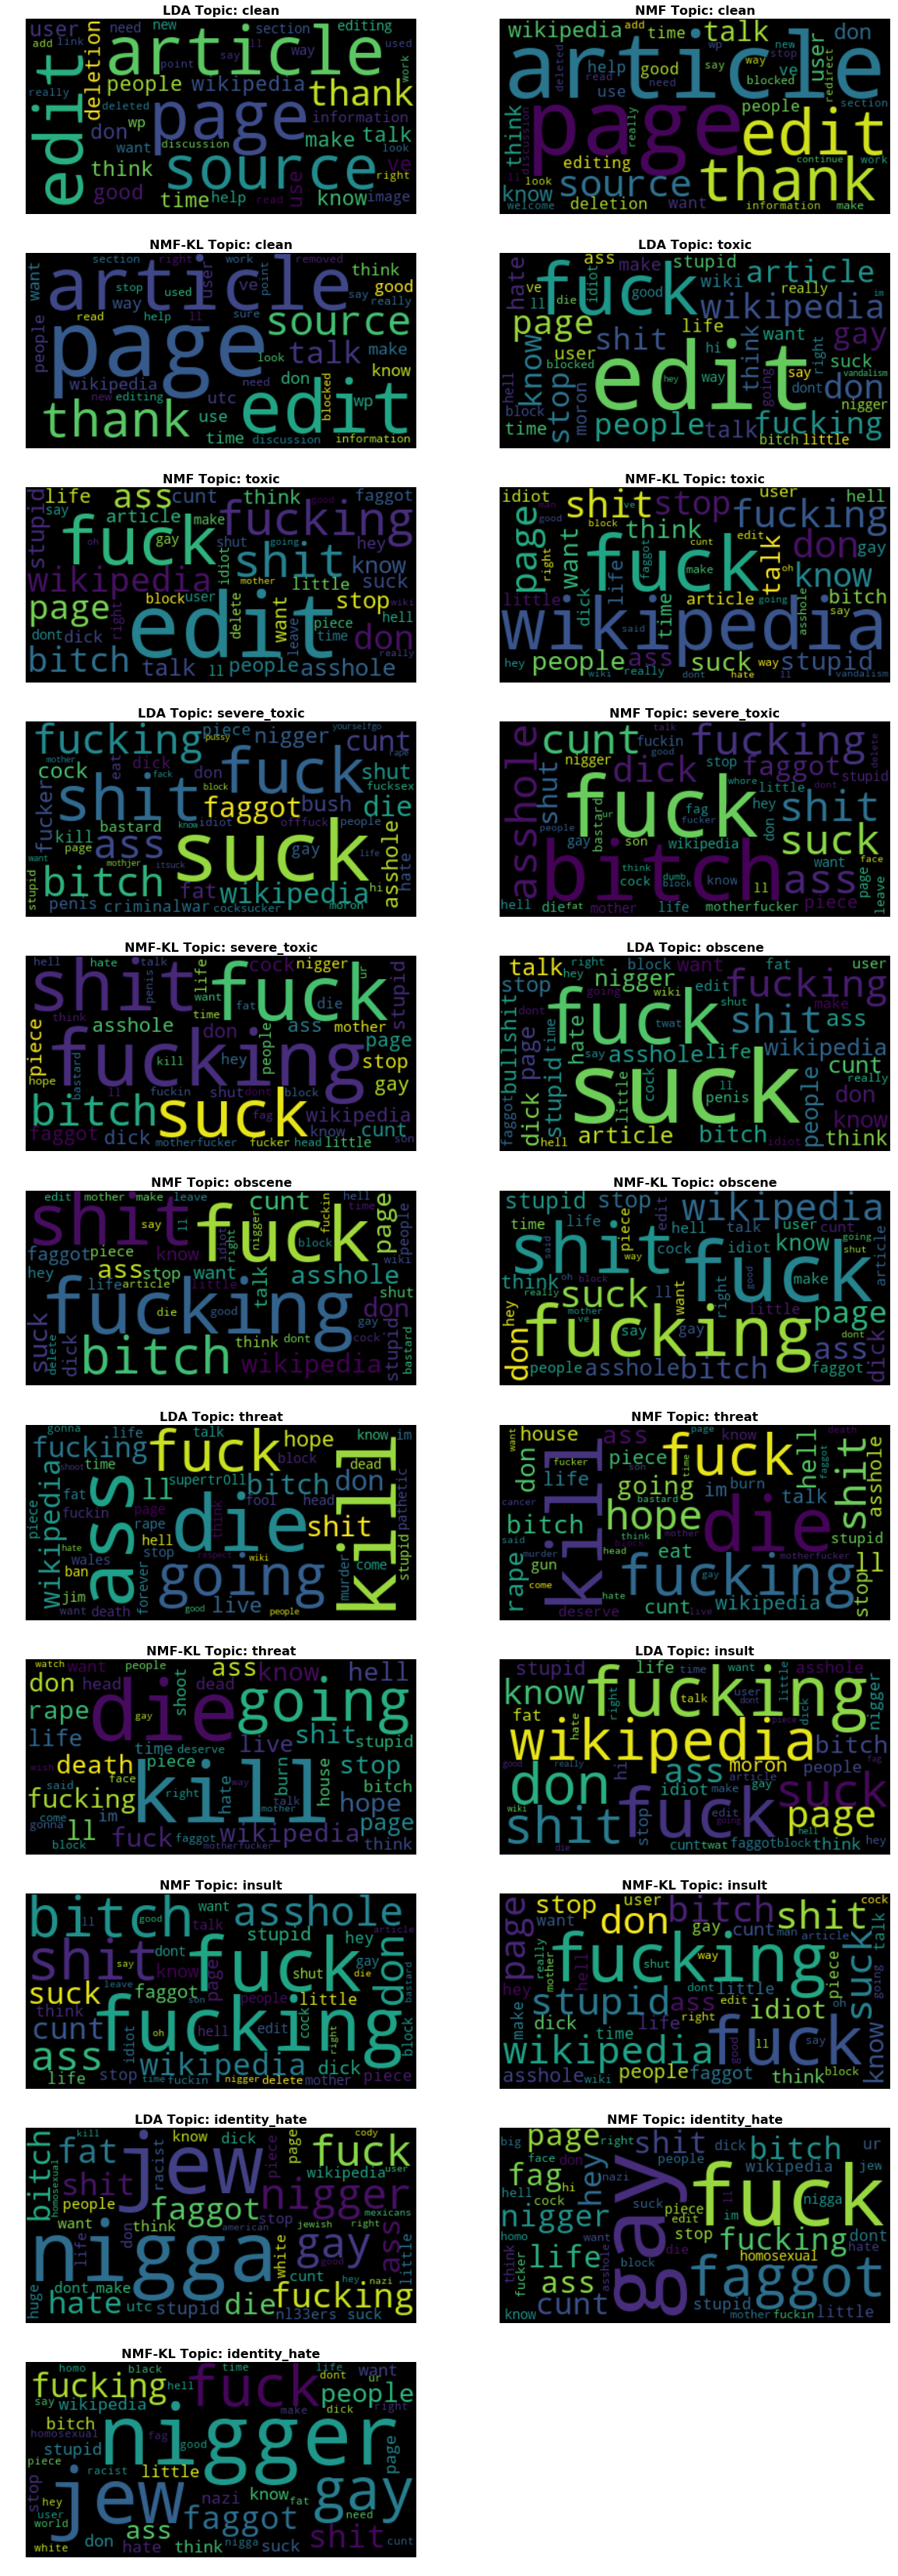

In [60]:
mw = prep_dict(tnd,model_list)
mw = pd.DataFrame(mw)

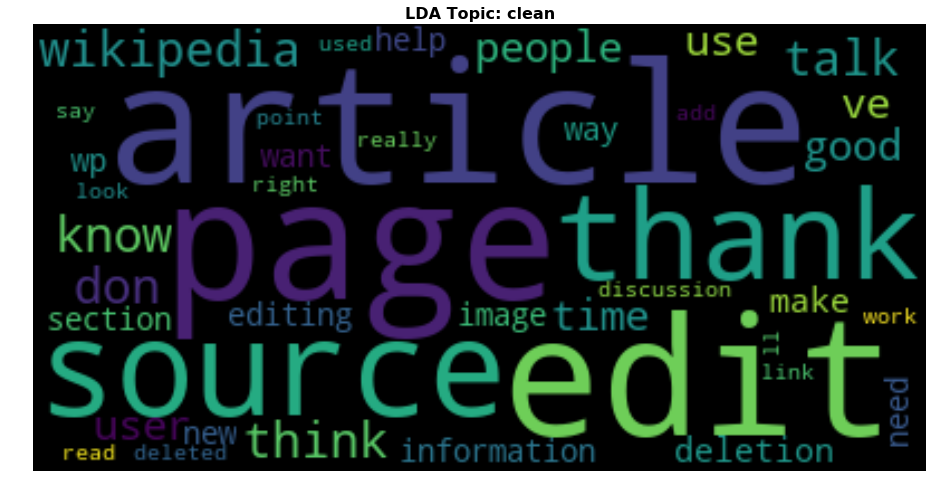

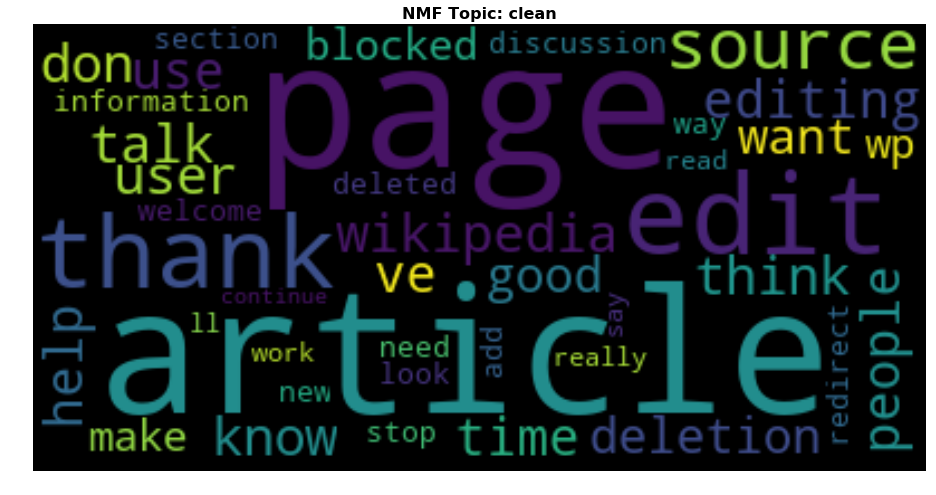

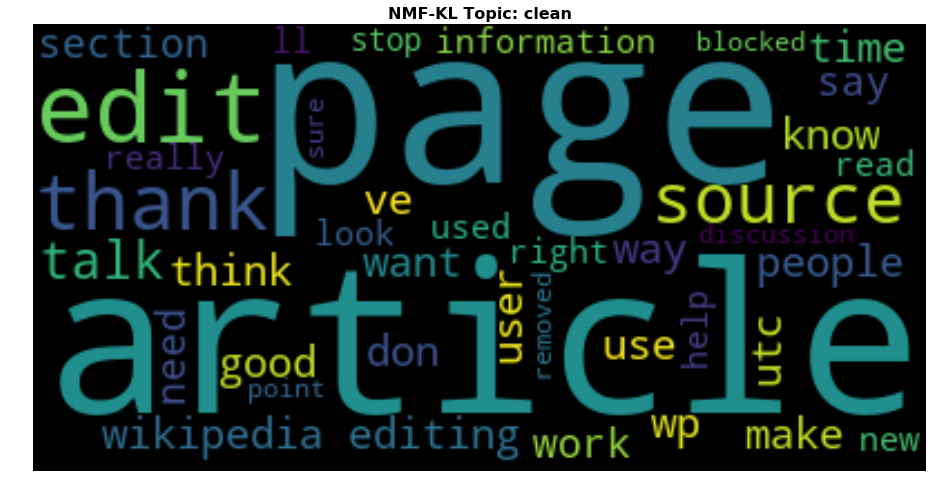

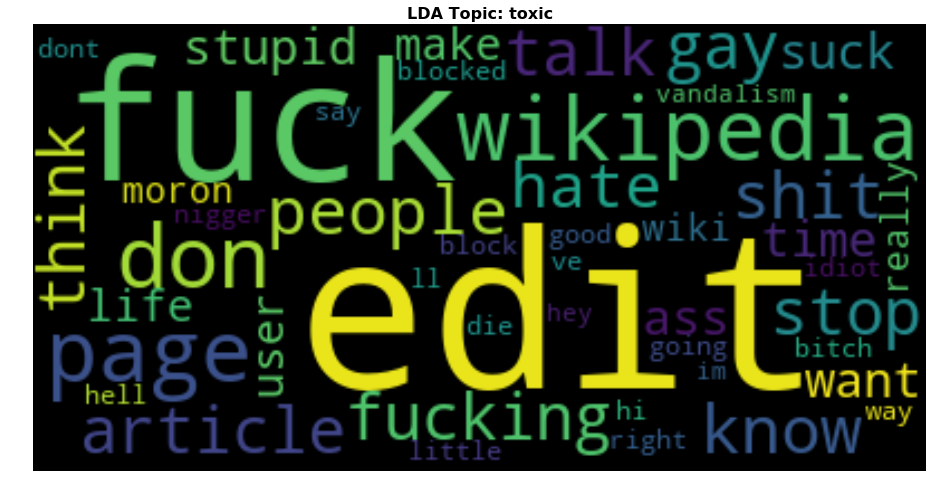

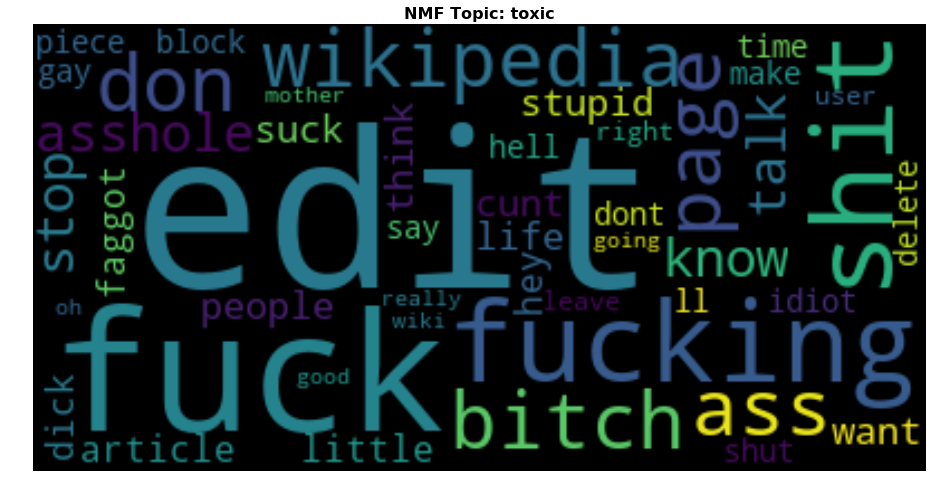

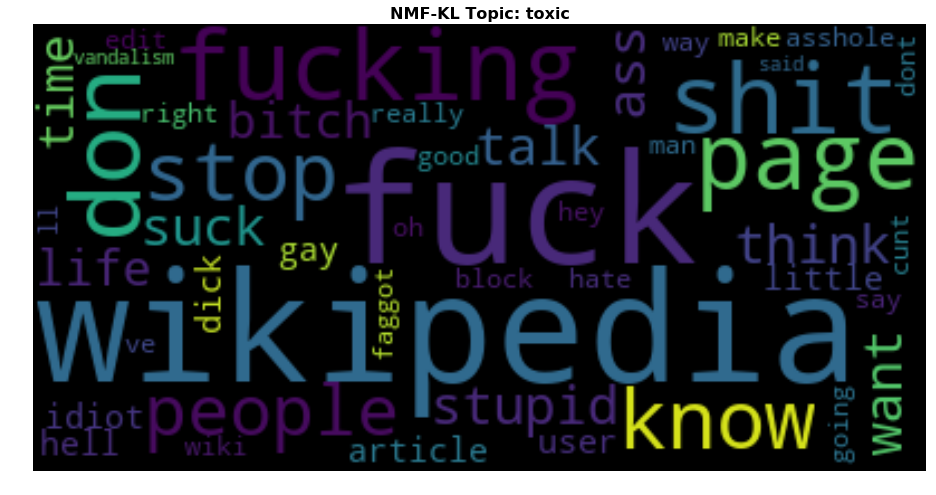

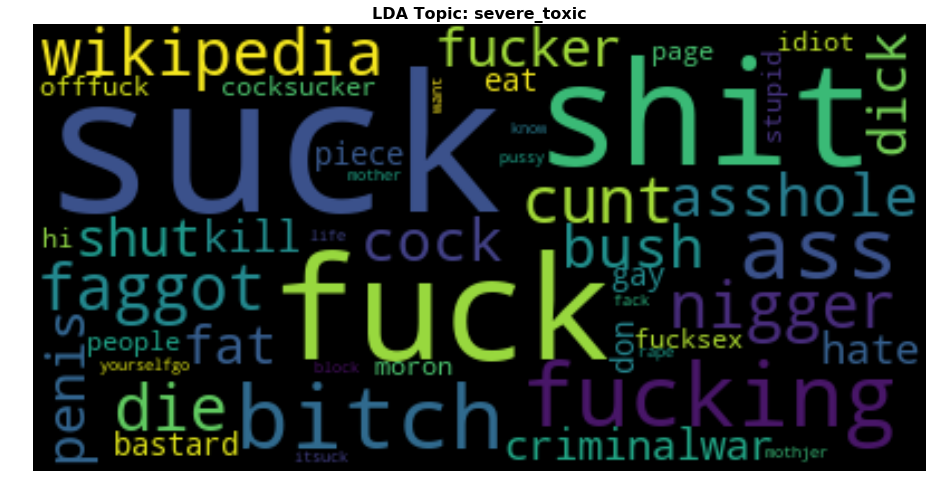

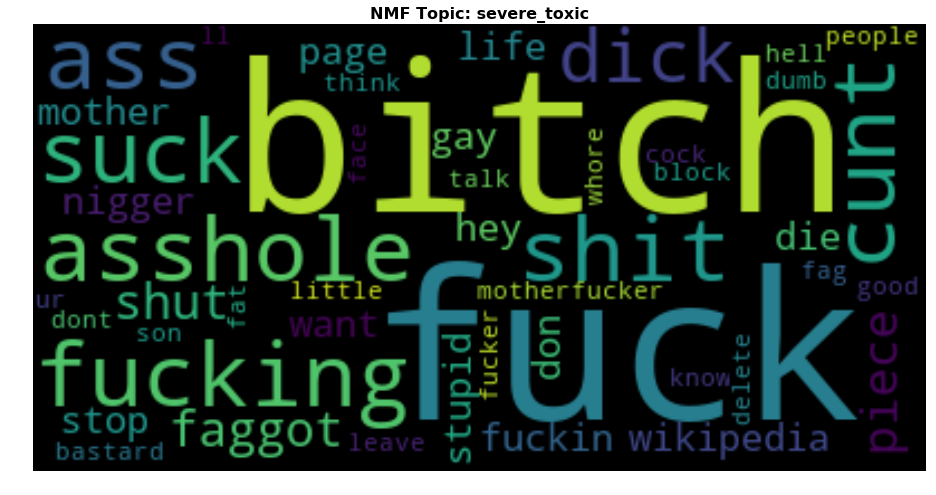

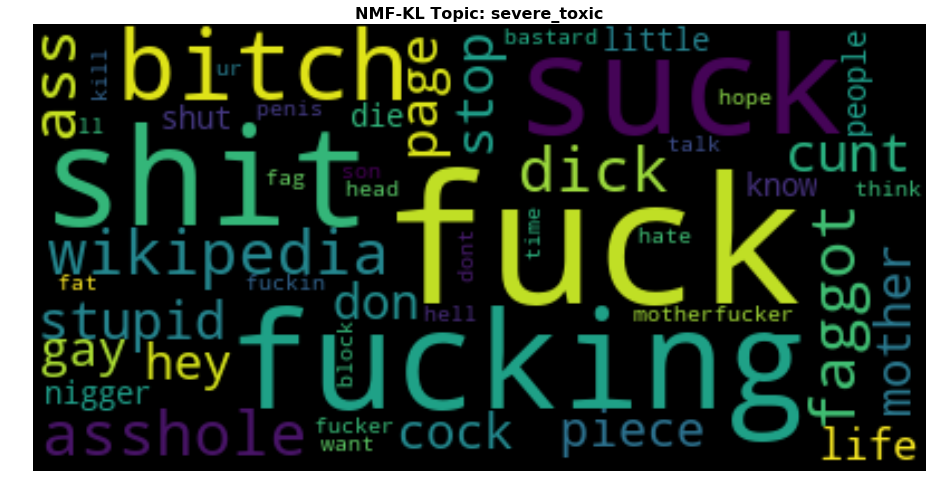

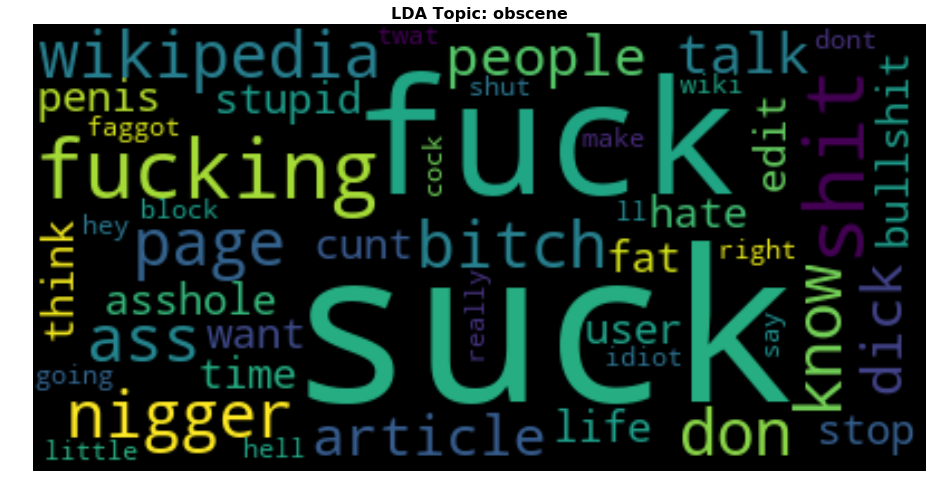

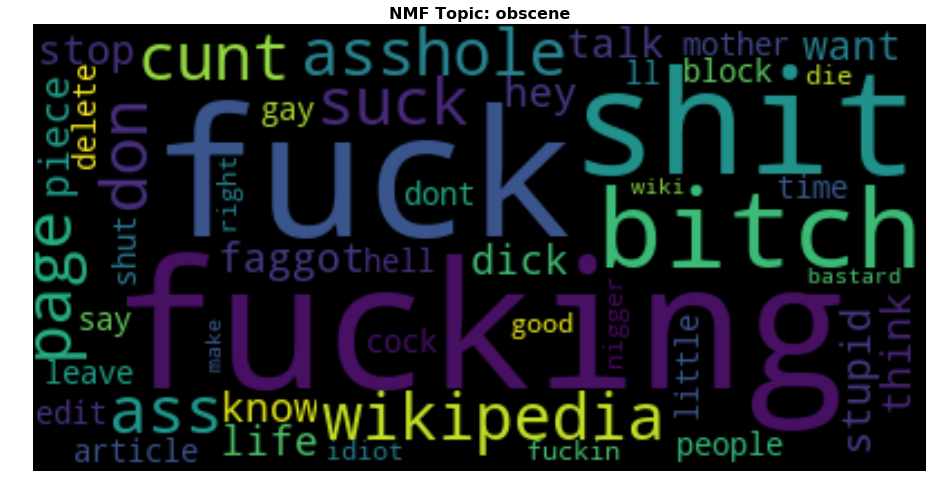

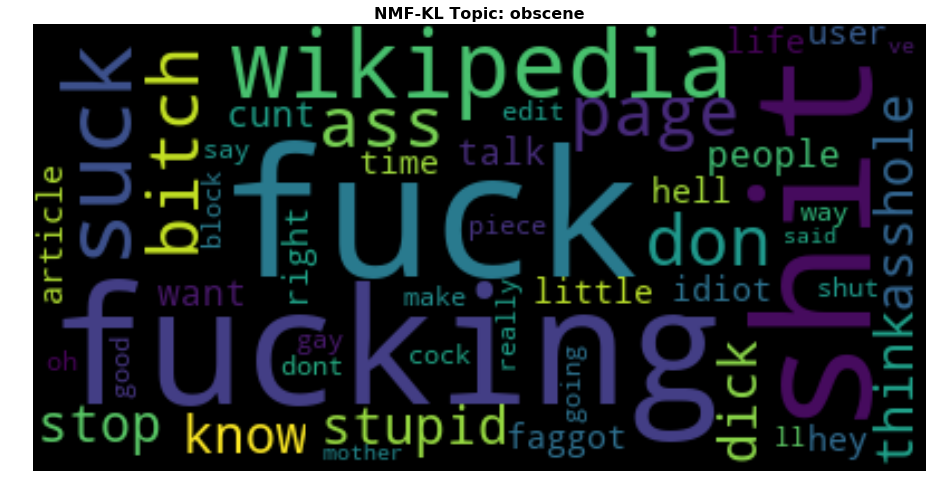

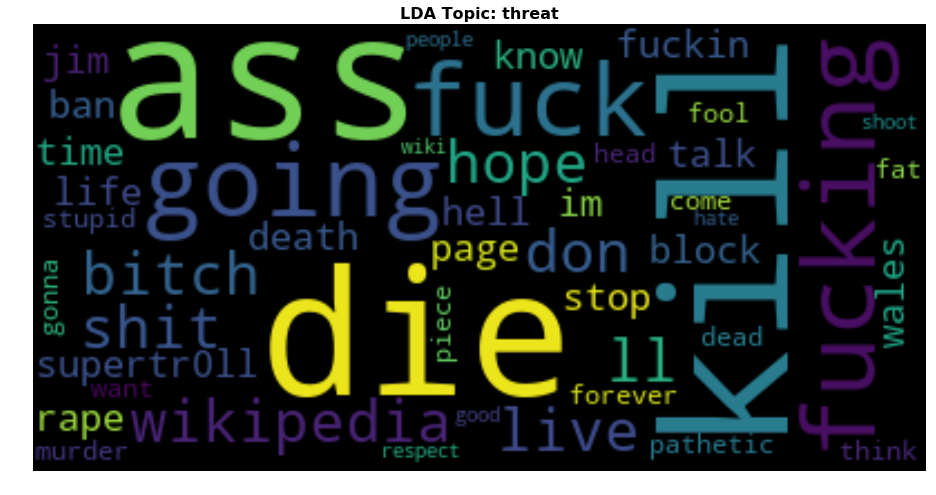

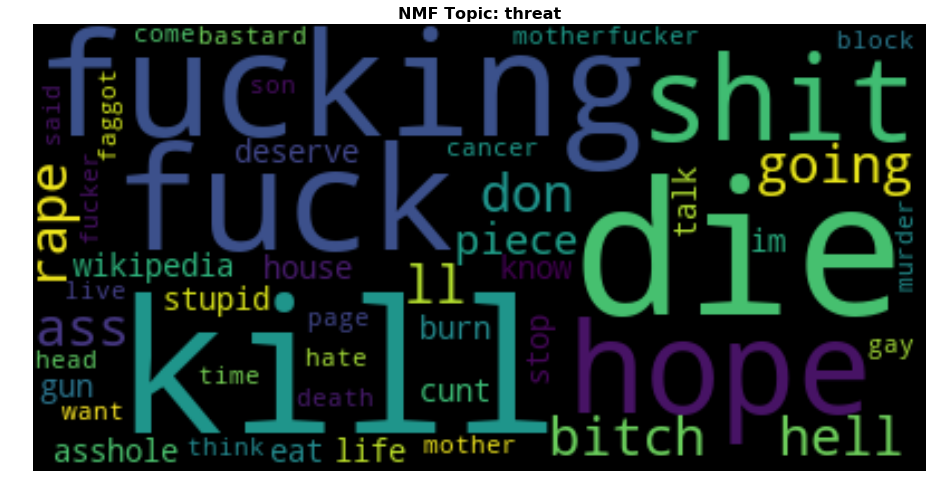

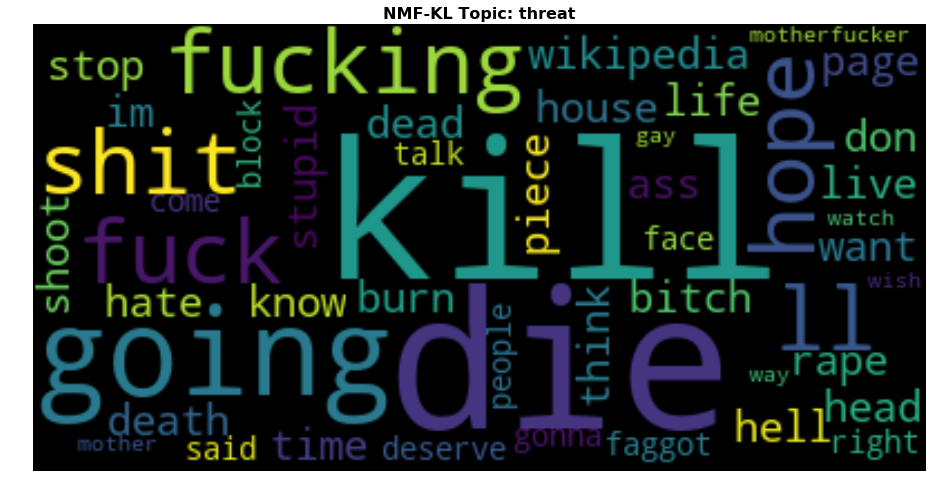

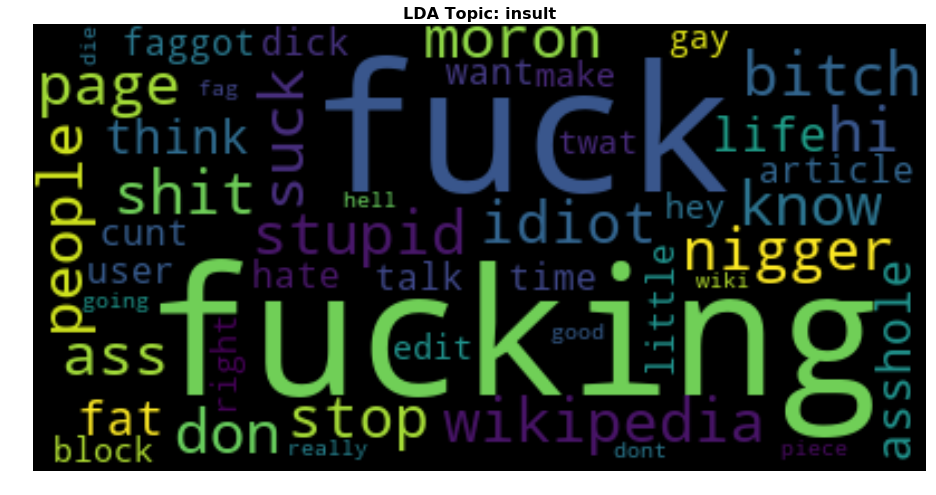

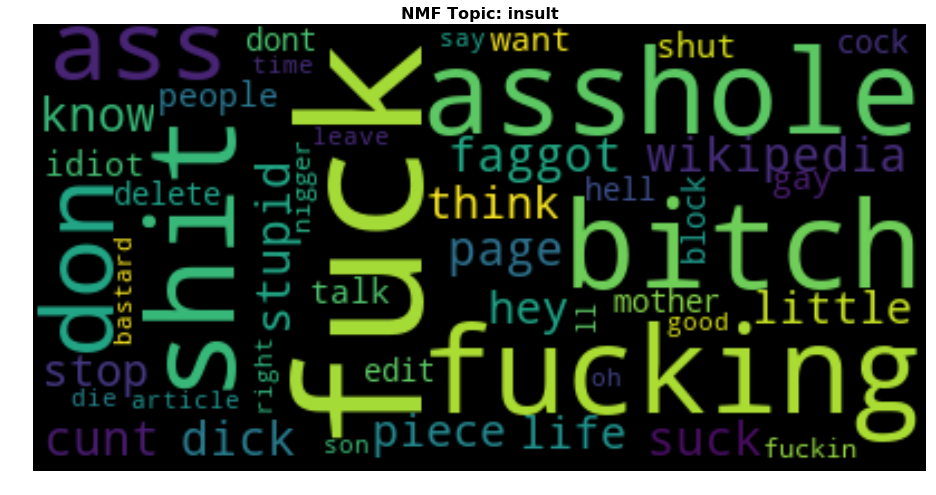

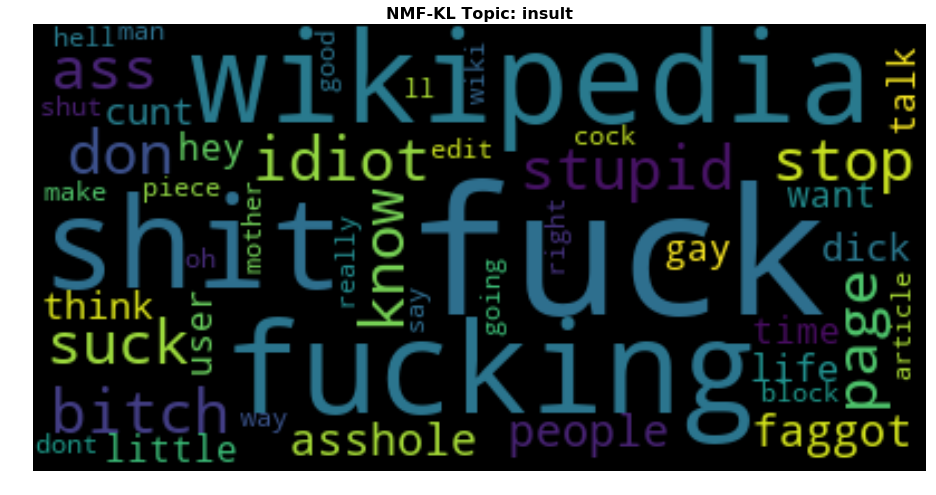

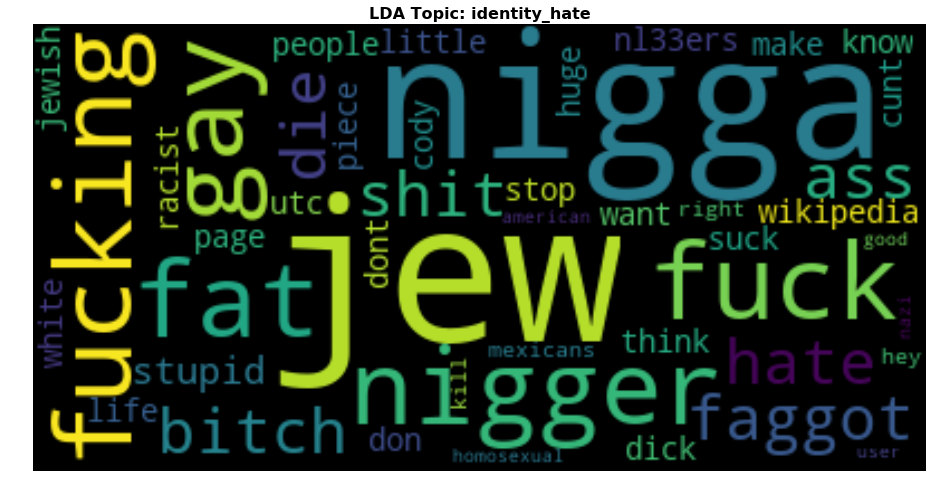

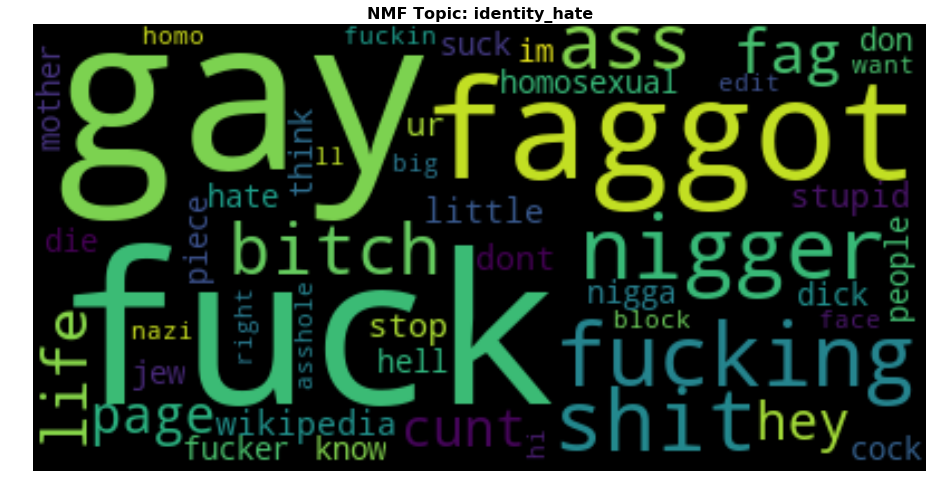

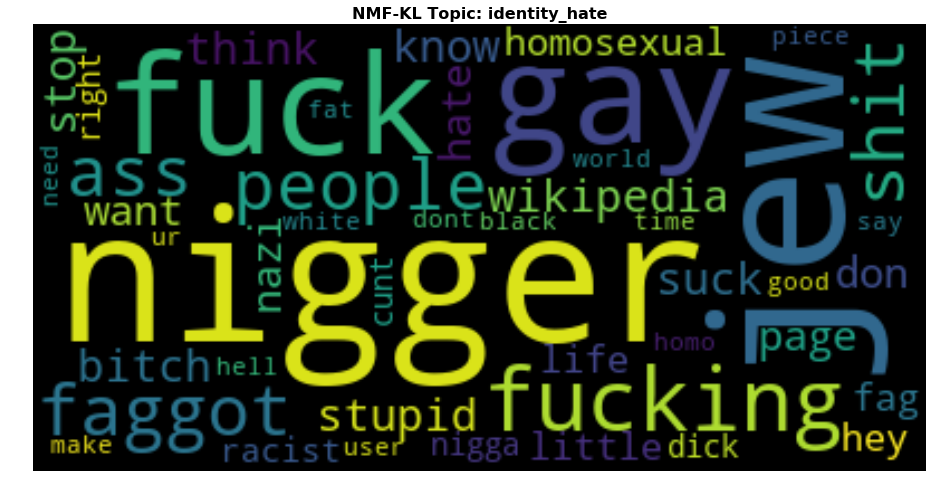

In [22]:
# mw = prep_dict(tnd,model_list)
# mw = pd.DataFrame(mw)

In [24]:
# mw